# Home Credit Default Risk
This notebook is based on the above named kaggle competition. <br>
The goal of this competition is predicting credit defaults based on a large number of variables. <br>

As shown in the graphic below, the available data consinst of a main dataset and multiple supplementary datasets which are connected through either a unique credit or client ID. <br>
<br>

![title](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

My personal goal is to achieve a ROC score of at least 0.8, which would have been enough to place among the winners of this competition in 2018.

## TODO
- Reduce memory usage (ongoing)
- Include all supplementary datasets
- Additional feature engineering (polynomial features maybe?)
- Remove redundant features and features without information content, look at correlations
- Hyperparameter tuning & cross-validation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb
import gc
import sys

### Main dataset
The main dataset contains a unique credit identifiers SK_ID_CURR, 120 independent variables and a target variable indicating if the debtor defaulted on the credit.

In [2]:
df = pd.read_csv('./home-credit-default-risk/application_train.csv')
print(len(df))
df.head()

307511


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Reduce memory usage
This dataset exceeds the memory limit on kaggle very quickly. I try to reduce the memory usage by converting columns to less memory intensive data types.

In [3]:
def return_size(df):
    ## get dataframe size in GB
    return round(sys.getsizeof(df) / 1e9, 2)

def reduce_memory(df):
    original_memory = df.memory_usage().sum()
    
    # Iterate through columns
    for col in df:
        
        # ID to 32 bit integer
        if ('SK_ID' in col):
            df[col] = df[col].fillna(0).astype(np.int32)
            
        # objects to category
        elif (df[col].dtype == 'object') and (df[col].nunique() < df.shape[0]):
            df[col] = df[col].astype('category')
        
        # 1/0 integers to booleans
        elif list(df[col].unique()) == [1, 0]:
            df[col] = df[col].astype(bool)
        
        # Float64 to float32
        elif df[col].dtype == float:
            df[col] = df[col].astype(np.float32)
            
        # 64 bit integers to 32 bit
        elif df[col].dtype == int:
            df[col] = df[col].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    print('Original Memory Usage: {} GB.'.format(round(original_memory / 1e9, 2)))
    print('New Memory Usage: {} GB.'.format(round(new_memory / 1e9, 2)))
        
    return df

In [4]:
df = reduce_memory(df).copy()

Original Memory Usage: 0.3 GB.
New Memory Usage: 0.13 GB.


### Taking a look at a few variables
I examine a few of the variables, to check if are any potential problems.

#### Length of Employment
The distribution of days in employment looks off. There is a large number of clients with a reported length of employment of -1000 years. It is probably a flag of some sort. <br>
I replace these values with nan and add an additional flag. <br>
The distribution looks reasonable after this step, with a minimum of 0 years (unemployed) and a maximum of 49 years.

In [5]:
(df.DAYS_EMPLOYED / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [6]:
df.loc[(df.DAYS_EMPLOYED / -365) < 0, 'DAYS_EMPLOYED'].value_counts()

365243    55374
Name: DAYS_EMPLOYED, dtype: int64

In [7]:
df['DAYS_EMPLOYED_flagged'] = df["DAYS_EMPLOYED"] == 365243
df.loc[df.DAYS_EMPLOYED_flagged == True, 'DAYS_EMPLOYED'] = np.nan

In [8]:
(df.DAYS_EMPLOYED / -365).describe()

count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

### Feature engineering
I construct three new features which might be useful to predict default risk. <br>
First the ratios of credit sum to income and yearly annuity to income and secondly the length of the credit contract, calculated as the annuity divided by the credit sum.

In [9]:
df['income_pct'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['income_pct'].describe().round(2)

count    307511.00
mean          3.96
std           2.69
min           0.00
25%           2.02
50%           3.27
75%           5.16
max          84.74
Name: income_pct, dtype: float64

In [10]:
df['annuity_pct'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['annuity_pct'].describe().round(2)

count    307499.00
mean          0.18
std           0.09
min           0.00
25%           0.11
50%           0.16
75%           0.23
max           1.88
Name: annuity_pct, dtype: float64

In [11]:
df['credit_term'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['credit_term'].describe().round(2)

count    307499.00
mean          0.05
std           0.02
min           0.02
25%           0.04
50%           0.05
75%           0.06
max           0.12
Name: credit_term, dtype: float64

#### Preprocessing data
I use FastAIs TabularDataLoaders class to simplify all steps of data preprocessing. <br>
Categorical features are ordinal encoded, missing values are filled in as 0 and a *missing* flag is added and continuous variables are normalized.
Finally, the dataset is separated into training and validation sets.

In [13]:
cont_names, cat_names = cont_cat_split(df, dep_var='TARGET')

procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(df, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names='TARGET', y_block=CategoryBlock, bs=512)
dls.show_batch()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,DAYS_EMPLOYED_flagged,AMT_ANNUITY_na,AMT_GOODS_PRICE_na,DAYS_EMPLOYED_na,OWN_CAR_AGE_na,CNT_FAM_MEMBERS_na,EXT_SOURCE_1_na,EXT_SOURCE_2_na,EXT_SOURCE_3_na,APARTMENTS_AVG_na,BASEMENTAREA_AVG_na,YEARS_BEGINEXPLUATATION_AVG_na,YEARS_BUILD_AVG_na,COMMONAREA_AVG_na,ELEVATORS_AVG_na,ENTRANCES_AVG_na,FLOORSMAX_AVG_na,FLOORSMIN_AVG_na,LANDAREA_AVG_na,LIVINGAPARTMENTS_AVG_na,LIVINGAREA_AVG_na,NONLIVINGAPARTMENTS_AVG_na,NONLIVINGAREA_AVG_na,APARTMENTS_MODE_na,BASEMENTAREA_MODE_na,YEARS_BEGINEXPLUATATION_MODE_na,YEARS_BUILD_MODE_na,COMMONAREA_MODE_na,ELEVATORS_MODE_na,ENTRANCES_MODE_na,FLOORSMAX_MODE_na,FLOORSMIN_MODE_na,LANDAREA_MODE_na,LIVINGAPARTMENTS_MODE_na,LIVINGAREA_MODE_na,NONLIVINGAPARTMENTS_MODE_na,NONLIVINGAREA_MODE_na,APARTMENTS_MEDI_na,BASEMENTAREA_MEDI_na,YEARS_BEGINEXPLUATATION_MEDI_na,YEARS_BUILD_MEDI_na,COMMONAREA_MEDI_na,ELEVATORS_MEDI_na,ENTRANCES_MEDI_na,FLOORSMAX_MEDI_na,FLOORSMIN_MEDI_na,LANDAREA_MEDI_na,LIVINGAPARTMENTS_MEDI_na,LIVINGAREA_MEDI_na,NONLIVINGAPARTMENTS_MEDI_na,NONLIVINGAREA_MEDI_na,TOTALAREA_MODE_na,OBS_30_CNT_SOCIAL_CIRCLE_na,DEF_30_CNT_SOCIAL_CIRCLE_na,OBS_60_CNT_SOCIAL_CIRCLE_na,DEF_60_CNT_SOCIAL_CIRCLE_na,DAYS_LAST_PHONE_CHANGE_na,AMT_REQ_CREDIT_BUREAU_HOUR_na,AMT_REQ_CREDIT_BUREAU_DAY_na,AMT_REQ_CREDIT_BUREAU_WEEK_na,AMT_REQ_CREDIT_BUREAU_MON_na,AMT_REQ_CREDIT_BUREAU_QRT_na,AMT_REQ_CREDIT_BUREAU_YEAR_na,annuity_pct_na,credit_term_na,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,income_pct,annuity_pct,credit_term,TARGET
0,Cash loans,F,N,N,0,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,True,True,1,True,False,0,Core staff,3,3,MONDAY,0,0,0,0,0,0,Medicine,#na#,#na#,#na#,#na#,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,True,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True

## Running a few quick models
To get a baseline, I run three simple models on the main dataset.

### Random Forest
I start of with a simple Random Forest. This model already achieves a ROC of 0.72, which isnt too bad.

In [14]:
rf = RandomForestClassifier(n_estimators = 200, random_state = 42, verbose = 1, n_jobs = -1)

In [15]:
rf.fit(dls.train.xs, dls.train.y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   22.6s finished


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

In [16]:
roc_auc_score(dls.valid.y, rf.predict_proba(dls.valid.xs)[:, 1])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.3s finished


0.722008411389307

In [17]:
gc.enable()
del rf
gc.collect()

308

### Neural net
A very basic neural net with two hidden layers performs a bit better with a ROC of 0.75.

In [18]:
learn = tabular_learner(dls, metrics=[RocAucBinary()])

SuggestedLRs(valley=0.0008317637839354575)

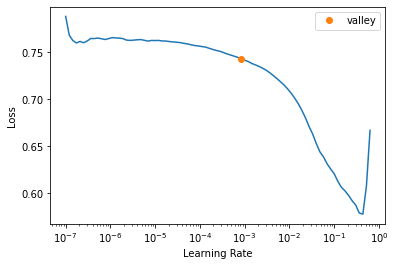

In [19]:
learn.lr_find()

In [22]:
learn.fit(5, 0.001)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.245120,0.248264,0.754723,00:07
1,0.248652,0.247977,0.754694,00:08
2,0.247342,0.247792,0.752117,00:08
3,0.244686,0.248593,0.750875,00:08
4,0.244543,0.247244,0.755675,00:08


In [23]:
gc.enable()
del learn
gc.collect()

14794

### Gradient boosting
Basically all top entries in the competition use boosted random forests. <br>
Unsurprisingly, I get the best result so far (0.77) when using LightGBM. The neural net is almost as good as the boosting machine, it would be very interesting to see if I can beat LightGBM by tuning the hidden layers.

In [24]:
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', class_weight = 'balanced', 
                           learning_rate = 0.05, reg_alpha = 0.1, reg_lambda = 0.1, 
                           subsample = 0.8, n_jobs = -1, random_state = 42)

In [25]:
def fit_lgb(model, dls):
    valid_features =  np.array(dls.valid.xs)
    valid_labels = np.array(dls.valid.y)
    train_features =  np.array(dls.train.xs)
    train_labels = np.array(dls.train.y)
    cat_indices = [dls.valid.xs.columns.get_loc(col) for col in cat_names]
    
    model.fit(train_features, train_labels, eval_metric = 'auc',
          eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
          eval_names = ['valid', 'train'], categorical_feature = cat_indices,
          callbacks = [lgb.early_stopping(100), lgb.log_evaluation(100)])
    
    
def print_confusion(model, dls):
    valid_features =  np.array(dls.valid.xs)
    valid_labels = np.array(dls.valid.y)
    
    pred = model.predict(valid_features)
    cm = confusion_matrix(valid_labels, pred)
    
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual No Default', 'Actual Default'], 
                                 index=['Predict No Default', 'Predict Default'])
    
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [26]:
fit_lgb(model, dls)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Ove

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.786876	train's binary_logloss: 0.562134	valid's auc: 0.764181	valid's binary_logloss: 0.572415
[200]	train's auc: 0.811429	train's binary_logloss: 0.535776	valid's auc: 0.767801	valid's binary_logloss: 0.555742
[300]	train's auc: 0.828959	train's binary_logloss: 0.517586	valid's auc: 0.768257	valid's binary_logloss: 0.544703
Early stopping, best iteration is:
[281]	train's auc: 0.825822	train's binary_logloss: 0.520822	valid's auc: 0.768442	valid's binary_logloss: 0.546605


#### Confusion matrix
As we can see in the confusion matrix, the model already works significantly better than a random guess. <br>
However, it is still not good enough at predicting defaults. In 15488 cases, the model wasnt able to call the default. Only in 3347 cases the default was correctly predicted. <br>
There are also 1613 cases of false positives, which are probably the lesser evil when it comes to credit risk.

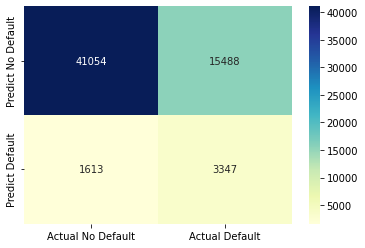

In [27]:
print_confusion(model, dls)

### Feature importance
This might be a good moment to take a look at the feature importance. <br>
I am happy to see that all three of my constructed variables seem to be pretty important. <br>
The clients employer seems to be extremely important, which I didnt expect.

In [28]:
def plot_feature_imp(dls, model):
    feature_imp = pd.DataFrame(sorted(zip(dls.xs.columns,model.feature_importances_)), columns=['Feature', 'Importance'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.sort_values(by='Importance', ascending=False)[0:20])
    plt.title('LightGBM Feature Importance')
    plt.tight_layout()
    plt.show()

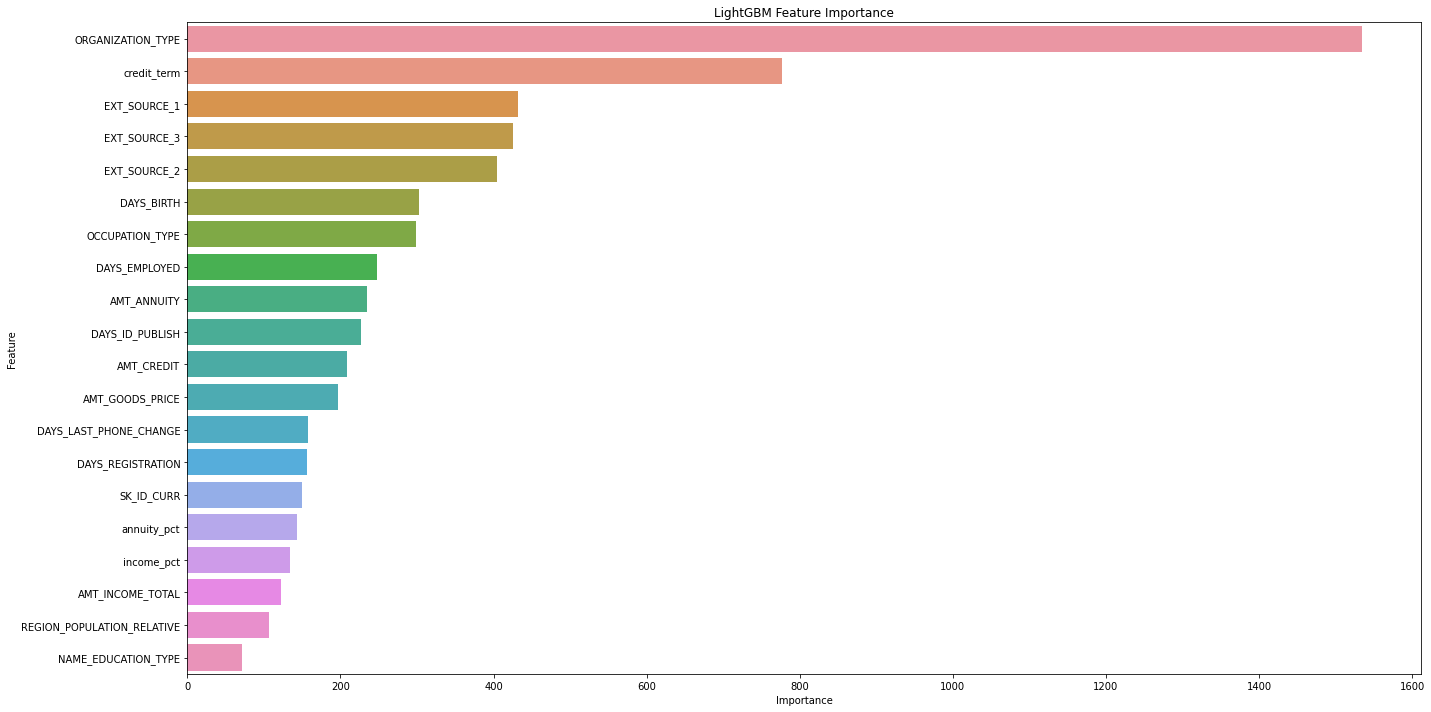

In [29]:
plot_feature_imp(dls, model)

#### Closer look at organization types
I take a closer look at the default rates for different organization types. <br>
The highest default rates are found in insecure, seasonal and low paid sectors like restaurants, construction, cleaning or farming. On the other hand, clients that work for the government, for example at universities, the police or military or schools have significantly lower default rates.

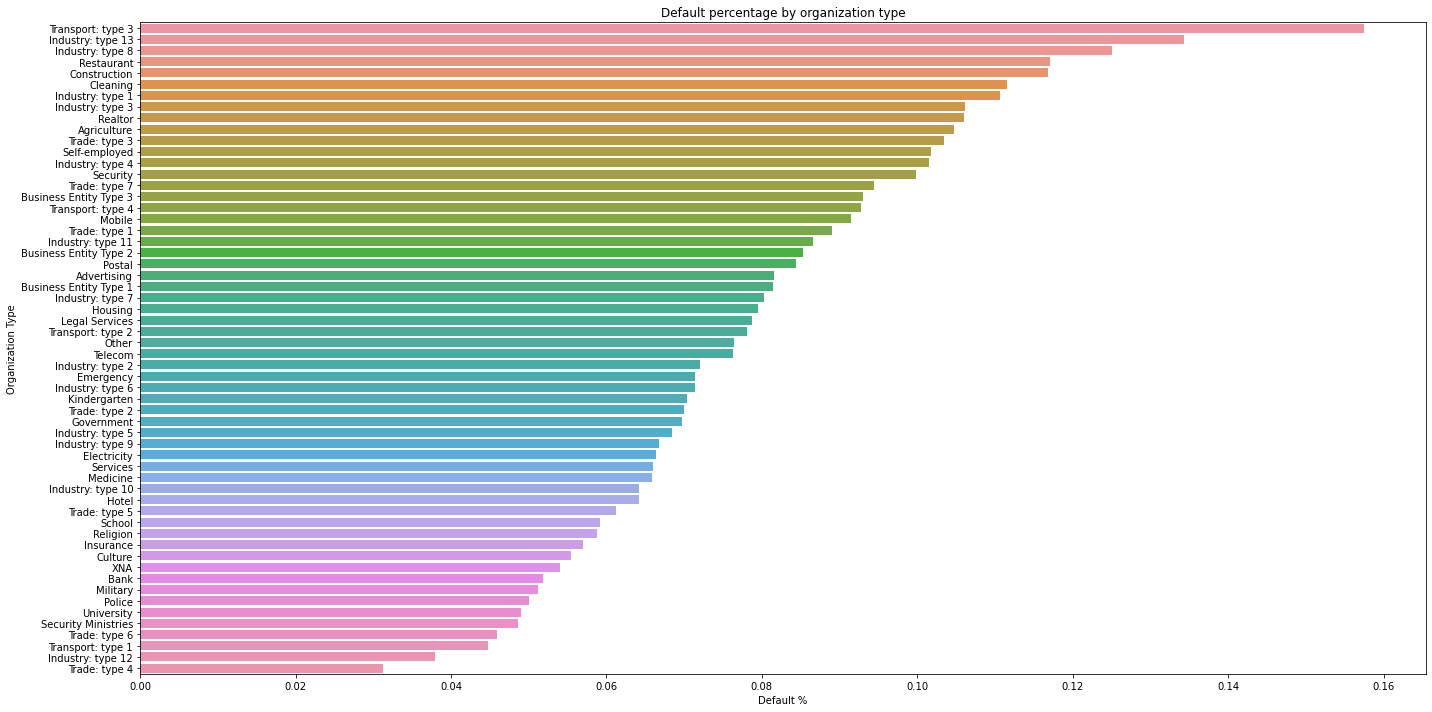

In [30]:
organization_types = df.ORGANIZATION_TYPE.value_counts().index.values
organization_types_default = []
for i in organization_types:
    pct = len(df[(df.ORGANIZATION_TYPE == i) & (df.TARGET == 1)]) / len(df[df.ORGANIZATION_TYPE == i])
    organization_types_default.append(pct)
    
organization_types = pd.DataFrame(zip(organization_types, organization_types_default), columns=['Organization Type', 'Default %'])

plt.figure(figsize=(20, 10))
sns.barplot(x='Default %', y='Organization Type', data=organization_types.sort_values(by='Default %', ascending=False))
plt.title('Default percentage by organization type')
plt.tight_layout()
plt.show()

#### Closer look at external source
The three external sources are all very important. I suspect them to be some sort of credit rating. <br>
The KDE plots show a significantly higher chance of default for lower values of these features.

In [31]:
def kdeplot(var):
    plt.figure(figsize = (12, 6))
    
    sns.kdeplot(df.loc[df['TARGET'] == 0, var], label = 'No Default')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var], label = 'Default')
    
    plt.xlabel(var); plt.ylabel('Density'); plt.title('{} Distribution'.format(var))
    plt.legend();

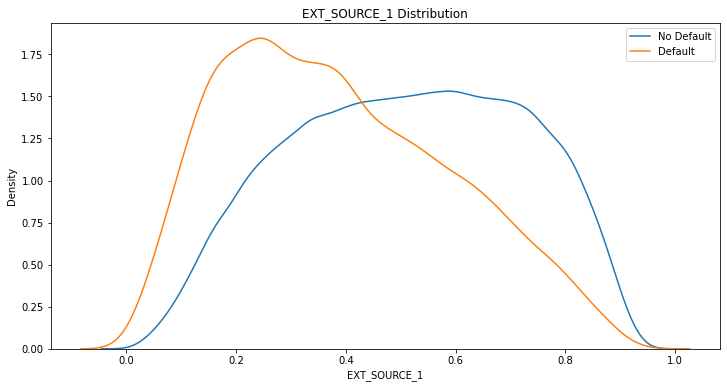

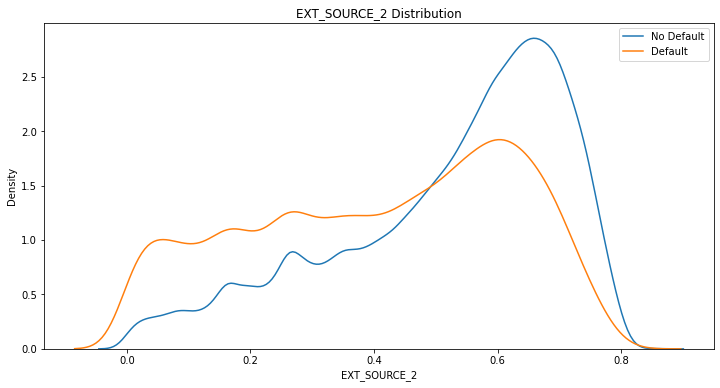

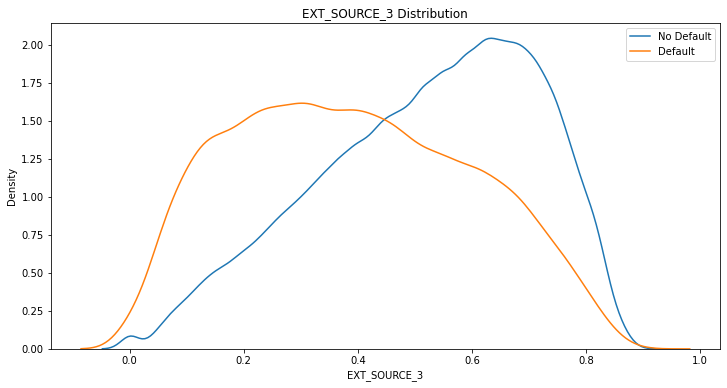

In [32]:
for i in range(1,4):
    kdeplot('EXT_SOURCE_{}'.format(i))